<a href="https://colab.research.google.com/github/MirvtMohamed/NER-LSTM/blob/main/NERLSTM4WithArabicFastText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# imports
import re
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(0)



In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
!wget https://raw.githubusercontent.com/SinaLab/ArabicNER/master/data/train.txt
!wget https://raw.githubusercontent.com/SinaLab/ArabicNER/master/data/test.txt
!wget https://raw.githubusercontent.com/SinaLab/ArabicNER/master/data/val.txt

--2025-05-12 00:00:01--  https://raw.githubusercontent.com/SinaLab/ArabicNER/master/data/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238880 (233K) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>] 233.28K  --.-KB/s    in 0.01s   

2025-05-12 00:00:02 (17.0 MB/s) - ‘train.txt’ saved [238880/238880]

--2025-05-12 00:00:02--  https://raw.githubusercontent.com/SinaLab/ArabicNER/master/data/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68139 (67K) [text/plain]
Saving to: ‘test.

In [ ]:
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm

# Use the 'error_bad_lines=False' parameter to skip bad lines during parsing
train_df = pd.read_csv('/content/train.txt', sep=r'\s+', engine='python', header=None, on_bad_lines='skip', names=['Word', 'Tag'])
val_df = pd.read_csv('/content/val.txt', sep=r'\s+', engine='python', header=None,  on_bad_lines='skip',names=['Word', 'Tag'])
test_df = pd.read_csv('/content/test.txt', sep=r'\s+', engine='python', header=None,  on_bad_lines='skip',names=['Word', 'Tag'])

# Check the structure of the train set
print(train_df.head(50))

         Word         Tag
0         فقد           O
1        حرصت           O
2       روسيا       B-ORG
3         على           O
4       تعطيل           O
5      مشاريع           O
6      قرارات           O
7      مختلفة           O
8          في           O
9        مجلس       B-ORG
10      الأمن       I-ORG
11         ضد       I-ORG
12     وتدخلت           O
13    عسكرياً           O
14       لقلب           O
15      الكفة           O
16     لصالحه           O
17          ،           O
18        $#$           O
19     مراسلة           O
20     سكرتير       B-OCC
21         في       I-OCC
22     لتأمين           O
23       مأكل           O
24       لشخص           O
25       واحد  B-CARDINAL
26          (           O
27       1948      B-DATE
28          )           O
29          .           O
30          2   B-ORDINAL
31          -           O
32      يعاقب           O
33         كل           O
34         من           O
35      ارتكب           O
36         أي           O
37         م

In [ ]:
print(train_df.head())
print(train_df.columns)


    Word    Tag
0    فقد      O
1   حرصت      O
2  روسيا  B-ORG
3    على      O
4  تعطيل      O
Index(['Word', 'Tag'], dtype='object')


In [ ]:
full_data = pd.concat([train_df, val_df, test_df], ignore_index=True)


In [ ]:
# Function to handle splitting multiple tags and sentence separation
def process_df(df):
    new_words = []
    new_tags = []
    sentence_nums = []
    sentence_num = 1  # Start sentence number at 1

    # Loop through the dataframe
    for idx, row in df.iterrows():
        word = row['Word']
        tag = row['Tag']

        # Skip sentence delimiters ('.', '$#$')
        if word in ['.', '$#$']:
            sentence_num += 1  # Move to the next sentence
            continue  # Skip appending this to the word and tag lists

        # Split the tag if there are multiple tags
        tag_parts = tag.split()

        for t in tag_parts:
            new_words.append(word)
            new_tags.append(t)
            sentence_nums.append(sentence_num)

    # Create a new DataFrame with the updated columns
    df_processed = pd.DataFrame({
        'Word': new_words,
        'Tag': new_tags,
        'Sentence #': sentence_nums
    })

    return df_processed

# Apply the function to train, validation, and test dataframes
data = process_df(full_data)


# Check the processed DataFrames
print(data.head(50))



         Word         Tag  Sentence #
0         فقد           O           1
1        حرصت           O           1
2       روسيا       B-ORG           1
3         على           O           1
4       تعطيل           O           1
5      مشاريع           O           1
6      قرارات           O           1
7      مختلفة           O           1
8          في           O           1
9        مجلس       B-ORG           1
10      الأمن       I-ORG           1
11         ضد       I-ORG           1
12     وتدخلت           O           1
13    عسكرياً           O           1
14       لقلب           O           1
15      الكفة           O           1
16     لصالحه           O           1
17          ،           O           1
18     مراسلة           O           2
19     سكرتير       B-OCC           2
20         في       I-OCC           2
21     لتأمين           O           2
22       مأكل           O           2
23       لشخص           O           2
24       واحد  B-CARDINAL           2
25          

In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 8015
Unique tags in corpus: 41


In [ ]:
%pip install plotly-express

In [ ]:
# %pip install plotly-express
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data["Tag"].values))
num_tags = len(tags)

import plotly.express as px

fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")
fig.show()

In [ ]:
import tqdm
def sentence_integrate(data):
  agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           #s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()

sentences=sentence_integrate(data)

sentences[0]

<ipython-input-11-2f010f567ed8>:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



[('فقد', 'O'),
 ('حرصت', 'O'),
 ('روسيا', 'B-ORG'),
 ('على', 'O'),
 ('تعطيل', 'O'),
 ('مشاريع', 'O'),
 ('قرارات', 'O'),
 ('مختلفة', 'O'),
 ('في', 'O'),
 ('مجلس', 'B-ORG'),
 ('الأمن', 'I-ORG'),
 ('ضد', 'I-ORG'),
 ('وتدخلت', 'O'),
 ('عسكرياً', 'O'),
 ('لقلب', 'O'),
 ('الكفة', 'O'),
 ('لصالحه', 'O'),
 ('،', 'O')]

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

word2idx
tag2idx

{'I-ORDINAL': 0,
 'I-LANGUAGE': 1,
 'I-DATE': 2,
 'B-MONEY': 3,
 'B-CURR': 4,
 'I-EVENT': 5,
 'O': 6,
 'B-PRODUCT': 7,
 'I-PERS': 8,
 'B-UNIT': 9,
 'I-FAC': 10,
 'B-PERCENT': 11,
 'I-ORG': 12,
 'I-NORP': 13,
 'B-LANGUAGE': 14,
 'I-GPE': 15,
 'I-LOC': 16,
 'I-CURR': 17,
 'B-NORP': 18,
 'B-OCC': 19,
 'I-TIME': 20,
 'B-QUANTITY': 21,
 'I-LAW': 22,
 'B-PERS': 23,
 'B-FAC': 24,
 'B-GPE': 25,
 'B-WEBSITE': 26,
 'B-ORDINAL': 27,
 'B-ORG': 28,
 'B-DATE': 29,
 'B-CARDINAL': 30,
 'I-PRODUCT': 31,
 'I-MONEY': 32,
 'I-WEBSITE': 33,
 'B-EVENT': 34,
 'B-LAW': 35,
 'B-TIME': 36,
 'I-CARDINAL': 37,
 'B-LOC': 38,
 'I-PERCENT': 39,
 'I-OCC': 40}

Average Sentence Length: 16.28 words


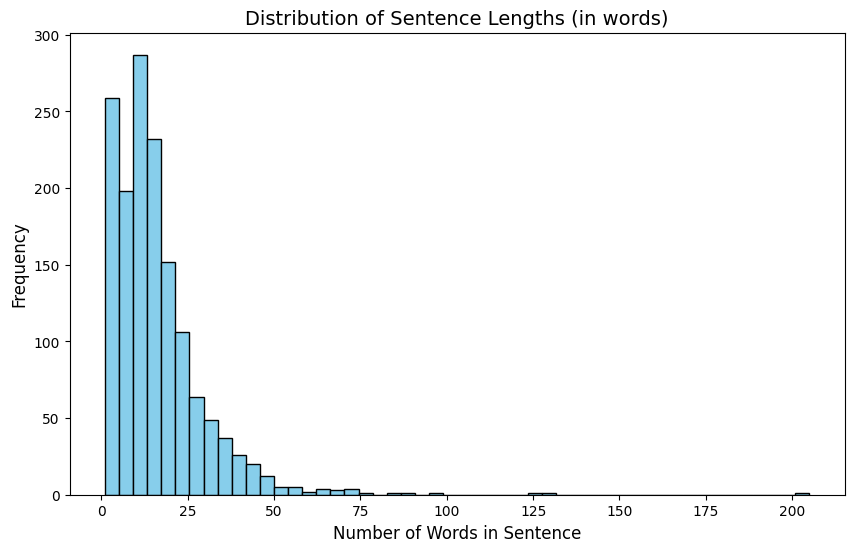

Min Sentence Length: 1
Max Sentence Length: 205
Standard Deviation of Sentence Lengths: 13.624240429834032


In [ ]:
import matplotlib.pyplot as plt

# Step 1: Group by 'Sentence #' and calculate the number of words in each sentence
sentence_word_counts = data.groupby('Sentence #')['Word'].count()

# Step 2: Calculate the average sentence length
avg_sentence_length = sentence_word_counts.mean()
print(f'Average Sentence Length: {avg_sentence_length:.2f} words')

# Step 3: Plot the distribution of sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(sentence_word_counts, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths (in words)', fontsize=14)
plt.xlabel('Number of Words in Sentence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Optionally, you can get some other statistics like min, max, and std
print(f'Min Sentence Length: {sentence_word_counts.min()}')
print(f'Max Sentence Length: {sentence_word_counts.max()}')
print(f'Standard Deviation of Sentence Lengths: {sentence_word_counts.std()}')


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 40

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])


##FastText Arabic

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
!gunzip cc.ar.300.vec.gz


--2025-05-12 00:00:22--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.33, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  48.3MB/s    in 9.3s    

2025-05-12 00:00:32 (131 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [ ]:
embedding_index = {}
with open('cc.ar.300.vec', encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector


In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((len(word2idx) + 1, embedding_dim))

for word, i in word2idx.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        # Random init if word not found
        embedding_matrix[i] = np.random.normal(0, 1, embedding_dim)

In [ ]:
#split into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [ ]:
!pip install keras-contrib

ERROR: Could not find a version that satisfies the requirement keras-contrib (from versions: none)
ERROR: No matching distribution found for keras-contrib


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, TimeDistributed, Dense

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=len(word2idx)+1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)(input_layer)

bilstm = Bidirectional(LSTM(units=64, return_sequences=True))(embedding_layer)
output = TimeDistributed(Dense(len(tag2idx), activation="softmax"))(bilstm)

model = Model(input_layer, output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 40, 300)        │     2,405,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 40, 128)        │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 40, 41)         │         5,289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,597,269 (9.91 MB)

 Trainable params: 192,169 (750.66 KB)

 Non-trainable params: 2,405,100 (9.17 MB)

In [ ]:
%pip install livelossplot

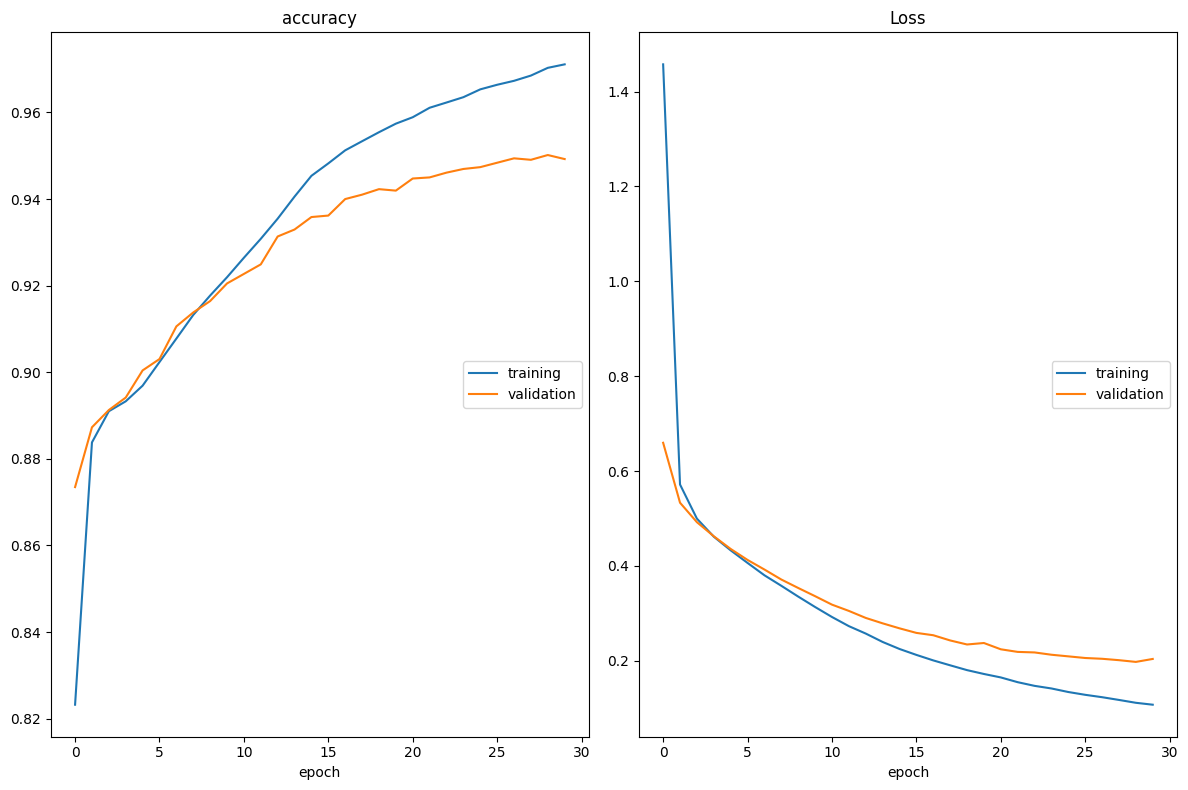

accuracy
	training         	 (min:    0.823, max:    0.971, cur:    0.971)
	validation       	 (min:    0.873, max:    0.950, cur:    0.949)
Loss
	training         	 (min:    0.108, max:    1.457, cur:    0.108)
	validation       	 (min:    0.198, max:    0.660, cur:    0.204)

Epoch 30: val_loss did not improve from 0.19788
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9710 - loss: 0.1085 - val_accuracy: 0.9492 - val_loss: 0.2041


In [ ]:
#
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

#%%time

logdir="log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)#real time visualization

chkpt = ModelCheckpoint("model_weights.weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=7, verbose=0, mode='max', baseline=None, restore_best_weights=True)

callbacks = [PlotLossesCallback(), chkpt, early_stopping,tensorboard_callback]


history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=30,
    callbacks=callbacks,
    verbose=1

)

#Apply TensorBoard to check the detailed structure and performance
#%load_ext tensorboard

#%tensorboard --logdir log


In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

i = np.random.randint(0, x_test.shape[0])
print("This is sentence:",i)
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_test[i], p[0]):
    print("{:15}{:15}\t{}".format(words[w-1], tags[true], tags[pred]))
    #292


Evaluate on test data
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9512 - loss: 0.1942
test loss: 0.19788341224193573 
test accuracy: 0.9501694440841675 
This is sentence: 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Word           True 	 Pred

------------------------------
صور            O              	O
عن             O              	O
قرية           B-GPE          	B-GPE
كوكب           I-GPE          	I-GPE
الهوا          I-GPE          	I-GPE
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O              	O
والتي          O

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get all predictions
y_pred = model.predict(x_test, batch_size=128)
y_pred_classes = np.argmax(y_pred, axis=-1)  # Get predicted classes



3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_test_bin = label_binarize(y_test.flatten(), classes=list(range(num_tags)))

# Filter out classes with insufficient data for ROC-AUC calculation
valid_classes_roc = []
for i, tag in enumerate(tags):
    y_true_class = y_test_bin[:, i]
    if len(np.unique(y_true_class)) > 1:
        valid_classes_roc.append(i)

# Calculate and print ROC-AUC for valid classes
for i in valid_classes_roc:
    tag = tags[i]
    y_pred_class = y_pred[:, :, i].flatten()
    y_true_class = y_test_bin[:, i]

    auc = roc_auc_score(y_true_class, y_pred_class)
    print(f"Class {tag} ROC-AUC: {auc:.4f}")

Class I-ORDINAL ROC-AUC: 1.0000
Class I-DATE ROC-AUC: 0.9994
Class B-MONEY ROC-AUC: 0.8008
Class I-EVENT ROC-AUC: 0.9304
Class O ROC-AUC: 0.9868
Class B-PRODUCT ROC-AUC: 0.7906
Class I-PERS ROC-AUC: 0.9976
Class I-FAC ROC-AUC: 0.9864
Class I-ORG ROC-AUC: 0.9840
Class I-NORP ROC-AUC: 0.9743
Class B-LANGUAGE ROC-AUC: 0.9489
Class I-GPE ROC-AUC: 0.9955
Class I-LOC ROC-AUC: 0.9944
Class B-NORP ROC-AUC: 0.9723
Class B-OCC ROC-AUC: 0.9956
Class I-TIME ROC-AUC: 0.8490
Class I-LAW ROC-AUC: 0.9694
Class B-PERS ROC-AUC: 0.9953
Class B-FAC ROC-AUC: 0.9850
Class B-GPE ROC-AUC: 0.9956
Class B-WEBSITE ROC-AUC: 0.9777
Class B-ORDINAL ROC-AUC: 0.9984
Class B-ORG ROC-AUC: 0.9920
Class B-DATE ROC-AUC: 0.9963
Class B-CARDINAL ROC-AUC: 0.9819
Class I-PRODUCT ROC-AUC: 0.8395
Class I-MONEY ROC-AUC: 0.9997
Class I-WEBSITE ROC-AUC: 0.9950
Class B-EVENT ROC-AUC: 0.9468
Class B-LAW ROC-AUC: 0.9533
Class B-TIME ROC-AUC: 0.9211
Class I-CARDINAL ROC-AUC: 0.9969
Class B-LOC ROC-AUC: 0.9727
Class I-OCC ROC-AUC: 0.99

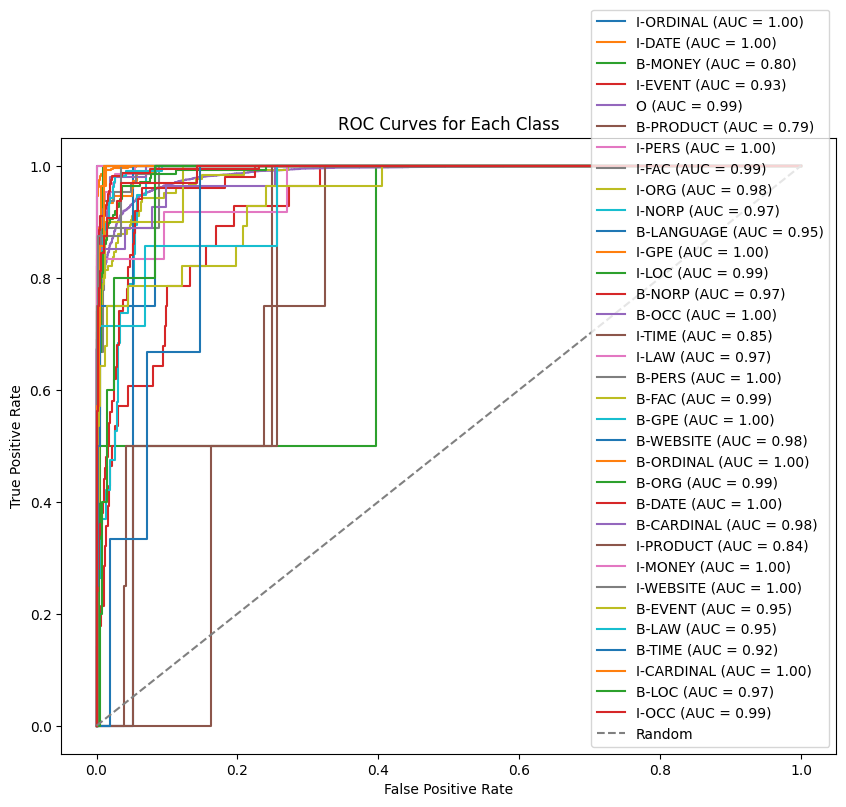

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_test_bin = label_binarize(y_test.flatten(), classes=list(range(num_tags)))

# Create a figure and axes
plt.figure(figsize=(10, 8))

# Filter out classes with insufficient data for plotting
valid_classes = []
for i, tag in enumerate(tags):
    y_true_class = y_test_bin[:, i]
    if len(np.unique(y_true_class)) > 1:
        valid_classes.append(i)

# Plot ROC curves for valid classes
for i in valid_classes:
    tag = tags[i]
    y_pred_class = y_pred[:, :, i].flatten()
    y_true_class = y_test_bin[:, i]

    fpr, tpr, thresholds = roc_curve(y_true_class, y_pred_class)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{tag} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')

plt.show()

In [ ]:
model.save('Ner.keras')